# Searching for rare cell-types: Part 1

In this notebook we will explore how to use perisomatic features to enrich our search space for unique or rare cells of interest in the MICrONS dataset. This tutorial walks through the two examples highlighted in Fig. 6 of the accompanying manuscript but can be extended to a wide variety of inihibitory cells.  

In [17]:
import pandas as pd
import numpy as np 
import pcg_skel
import matplotlib.pyplot as plt
import seaborn as sns
from meshparty import meshwork
import caveclient
import numpy as np
from meshparty import trimesh_io
from nglui.statebuilder import *
import skeleton_plot
%matplotlib inline

To start out, let's take a look at all the predicted inhibitory neurons in the dataset in the 2D UMAP embedding space. Note that this embedding only shows inhibitory neurons as it includes 120 Post-Synaptic Shape (PSS) features.

The following plot shows all the predicted inhibitory neurons in gray with the manually labeled cortical column cells in color (Fig. 4).

In [18]:
df = pd.read_pickle('../data/inhibitory_perisomatic_feats_v661.pkl')
#df = df.reset_index(drop = True)

In [19]:
#Custom color palette
color_dict = {'23P':'#8268DC',
              '4P':'#647FDC',
              '5P-IT':'#77BCDE',
              '5P-ET':'#87DD90',
              '5P-NP':'#85DEC9',
              '6P-CT':'#96DD70',
              '6P-IT':'#DCC86E',
              'BC':'#D68C66',
              'BPC':'#D3697C',
              'MC':'#D36BBA',
              'NGC':'#BC6BDB',
              'astrocyte':'#009245',
              'pericyte':'#754C24',
              'microglia':'#006837',
              'oligo':'#8CC63F',
              'OPC':'#998675',
              'error':'#899499'
    
}

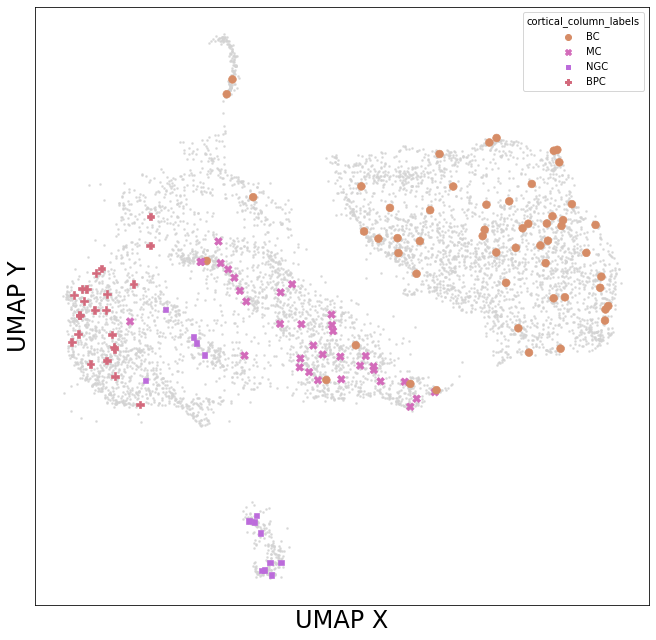

In [20]:
f, ax =plt.subplots(figsize=(11,11), facecolor='white')

sns.scatterplot( x='inhib_umap_embedding_x', y='inhib_umap_embedding_y', color='lightgray',
                ax =ax, s=5, alpha=0.9, edgecolor=None, data=df, legend = True)

sns.scatterplot( x='inhib_umap_embedding_x', y='inhib_umap_embedding_y', 
                ax =ax, s=60, alpha=1, hue='cortical_column_labels',style='cortical_column_labels',
                palette=color_dict, legend = True,
                c=(.2,.2,.2),edgecolor=None, data=df)

ax.set_xlabel('UMAP X', fontsize=24)
ax.set_ylabel('UMAP Y', fontsize=24)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Chandelier Cell

The Chandelier cell is a unique and well documented inhibitory cell-type in mammalian cortex. It is characterized by it's unique axonal morphology that form chains of vertical boutons 'candles' that almost exclusively synapse onto the axon initial segment of excitatory pyramidal cells (more specifically Layer 2/3 cells). However, they are sparsely distributed throughout upper cortical layers and thus identifying a collection of these cells presents a challenge.

Let's look at what one of these cell's look like in the MICrONS dataset

In [21]:
#Setting up our client to access the data
client = caveclient.CAVEclient('minnie65_public')

#Our nucleus table with all cells with a soma within the dataset
nuc_df = client.materialize.query_table('nucleus_detection_v0', split_positions=True, 
                                       desired_resolution=(1000,1000,1000))

In [22]:
chand_nuc_id = 485719
chand_cell = nuc_df.query('id == @chand_nuc_id').pt_root_id.values[0]

#This allows us to download meshes 
mm = trimesh_io.MeshMeta(cv_path=client.info.segmentation_source(), disk_cache_path='../minnie_meshes')

#Download our mesh of interest, NOTE the first time you run this may take a few minutes
mesh = mm.mesh(seg_id=chand_cell)

Let's skeletonize our cell - note the following cell may take a minute

In [23]:
#Defining our root point (the soma point in this case)
# chand_nuc_id = 485719
# root_id = nuc_df.query(f'id=={chand_nuc_id}').pt_root_id.values[0]
root_point = nuc_df.query(f'id=={chand_nuc_id}')[['pt_position_x', 'pt_position_y', 'pt_position_z']].iloc[0,:].values

#Skeletonizing our cell of interest
mw=pcg_skel.coord_space_meshwork(chand_cell, client=client, root_point=root_point, 
                                root_point_resolution=[nuc_df.attrs['dataframe_resolution']],
                                collapse_soma=True, synapses='all', 
                                synapse_table=client.materialize.synapse_table)

100%|██████████| 5606/5606 [00:00<00:00, 15768.55it/s]


In [24]:
#Adding volumetric properties
pcg_skel.features.add_volumetric_properties(mw, client)
pcg_skel.features.add_segment_properties(mw)

volume_df = mw.anno.segment_properties.df
# add column indicating skel index 
volume_df['skel_index'] = mw.anno.segment_properties.mesh_index.to_skel_index_padded
sk_volume_df = volume_df.drop_duplicates('skel_index').sort_values('skel_index').reset_index()
# pull out map for skel index -> radius
radius_labels = np.array(sk_volume_df['r_eff'])
mw.skeleton.vertex_properties['radius'] = radius_labels

#Adding a mask for the axon
axon_inds, Q = meshwork.algorithms.split_axon_by_annotation(mw, pre_anno='pre_syn', post_anno='post_syn')
mw.anno.add_annotations('is_axon', axon_inds, mask=True)

mw.mesh.vertices=mw.mesh.vertices/1000
mw.skeleton.vertices=mw.skeleton.vertices/1000

In [25]:
#Adding a filter to our presynapses to ensure the synapses are on the axon
presyn_df = mw.anno.pre_syn.df
axon_syn = []
for i in presyn_df.pre_pt_mesh_ind:
    if i in axon_inds:
        axon_syn.append(True)
    else:
        axon_syn.append(False)

presyn_df['is_axon'] = axon_syn
axon_syn_df = presyn_df.query('is_axon==True')
axon_syn_ids = axon_syn_df.id.tolist() #list of synapse ids on the axons

Here is the morphology of our chandelier cell of interest, you can see the characteristic vertical branches along the axon in gray.

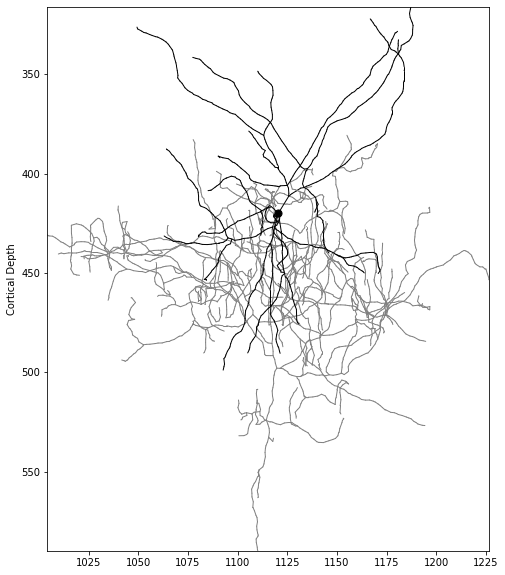

In [26]:
#list of indices to color differently
axon_skel_inds = mw.anno.is_axon.skel_index
skel_clist = []
for i in range(mw.skeleton.vertices.shape[0]):
    if i in axon_skel_inds.tolist():
        skel_clist.append(0)
    else:
        skel_clist.append(1)
        
len(skel_clist)


skel_cmap = {
    0:'gray', #axon 
    1:'black' #dendrite
}

f, ax = plt.subplots(figsize=(10, 10))

skeleton_plot.plot_tools.plot_mw_skel(mw, 
                                      plot_soma=True ,
                                      #radii=mw.skeleton.vertex_properties['radius']/200,
                                      invert_y=True,
                                      soma_size=50,
                                      skel_colors=skel_clist,
                                     skel_color_map=skel_cmap)

ax.set_ylabel('Cortical Depth')

plt.show()

To add synapses we'll query the synapse table and merge in the perisomatic predictions for all the target cells.

In [27]:
#Synapse table query for all synapses made by our cell of interest
syn_out_df = client.materialize.synapse_query(pre_ids=chand_cell,
                                             split_positions=True,
                                             desired_resolution=(1000,1000,1000))

#The cell-type table using the cell-class and subclass scheme applied in the manuscript
mm_df = client.materialize.query_table('aibs_metamodel_celltypes_v661', 
                                       split_positions=True, desired_resolution=(1000,1000,1000))

syn_out_df=syn_out_df.merge(mm_df[['id_ref', 'cell_type', 'pt_root_id']], 
                         left_on='post_pt_root_id', 
                         right_on='pt_root_id', how='left')



With the added synapses, you can see the characteristic vertical chains of synapses, as well as the target preference for Layer 2/3 pyramidal cells shown in purple.

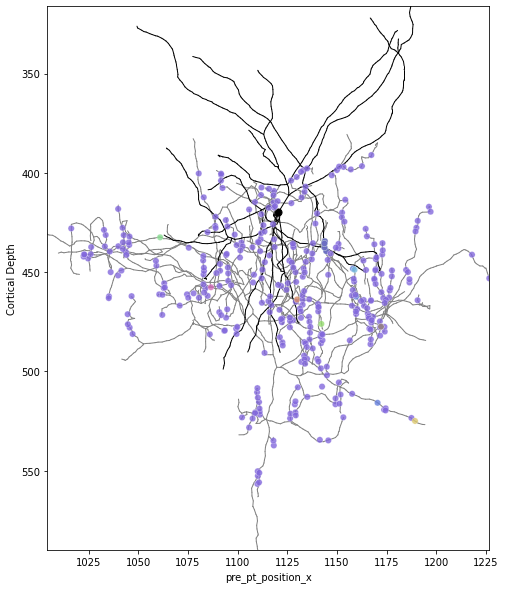

In [28]:

f, ax = plt.subplots(figsize=(10, 10))

#Plotting output synapses colored by predicted target subclass
sns.scatterplot(data = syn_out_df.query('id in @axon_syn_ids'),
                 x='pre_pt_position_x', y='pre_pt_position_y', hue = 'cell_type',
                 s=40, alpha=0.8, linewidth=0.3,
                 ax=ax, palette=color_dict, legend=False, zorder=25)  

skeleton_plot.plot_tools.plot_mw_skel(mw, 
                                      plot_soma=True ,
                                      #radii=mw.skeleton.vertex_properties['radius']/200,
                                      invert_y=True,
                                      soma_size=50,
                                      skel_colors=skel_clist,
                                     skel_color_map=skel_cmap)

ax.set_ylabel('Cortical Depth')
plt.show()

### Selecting nearest neighbors

Now that we have identified our cell of interest as a chandelier cell, we want to increase our sample set and identify more cells in the dataset that may also be chandelier. To do this we will use a KDTree graph based on the perisomatic features and select the top 20 nearest neighbors.

In [29]:
from sklearn.neighbors import KDTree

In [30]:
#Load the zscored perisomatic features for all predicted inhibitory cells
inhibitory_cells = np.load('../data/inhibitory_normalized_perisomatic_features.npy')

#KDTree on high dimensional feature space
kdt = KDTree(inhibitory_cells, leaf_size=30, metric='euclidean')

#Id of our chandelier cell of interest
idx = df.query('nucleus_id == @chand_nuc_id').index[0]
X = inhibitory_cells[idx,:].reshape(1,133) #corresponding feature vector for that cell

#Query for the top 20 nearest neighbors 
similar_idxs = kdt.query(X, k=20, return_distance=False)
similar_neurons = df.soma_id.to_numpy()[similar_idxs].tolist()[0]
similar_neuron_nuc_ids = df.nucleus_id.to_numpy()[similar_idxs].tolist()[0]

If we plot these nearest neighbors in the 2D UMAP embedding space we can see where in this feature space these cells are coming from. Note that the nearest neighbors were selected from the high dimensional feature space not the 2D embedding.

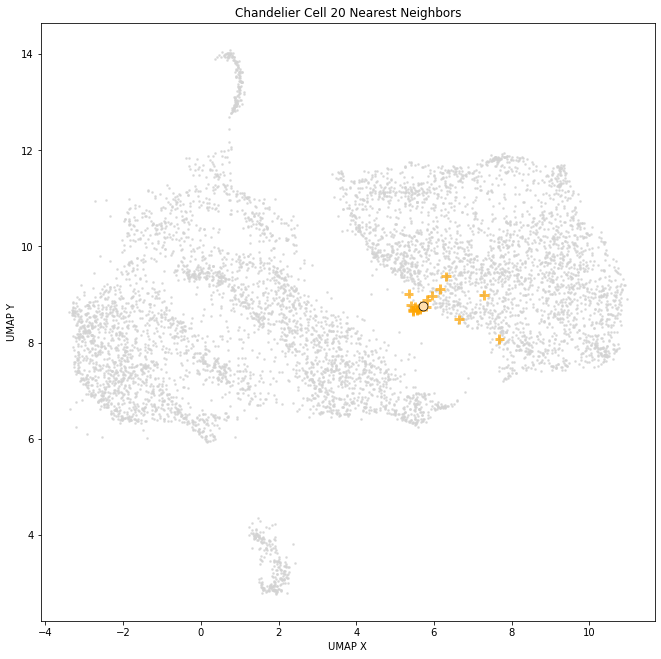

In [31]:
f, ax =plt.subplots(figsize=(11,11), facecolor='white')

sns.scatterplot( x='inhib_umap_embedding_x', y='inhib_umap_embedding_y', color='lightgray',
                ax =ax, s=5, alpha=0.9, edgecolor=None, data=df, legend = True)


sns.scatterplot(x='inhib_umap_embedding_x', y='inhib_umap_embedding_y', 
                ax =ax, alpha=.7, c = ['orange']*20,marker='+',linewidth=3,
                s=90, data=df.query('soma_id in @similar_neurons'))

sns.scatterplot(x='inhib_umap_embedding_x', y='inhib_umap_embedding_y', 
                ax =ax, alpha=1, c = ['navajowhite'],edgecolor='black',
                s=80, data=df.query('nucleus_id == @chand_nuc_id'))

ax.set_xlabel('UMAP X')
ax.set_ylabel('UMAP Y')
ax.set_title('Chandelier Cell 20 Nearest Neighbors')

plt.show()

## Are these cells in fact chandelier cells?

In [32]:
import math
from cell_search import get_angle_df, get_syn_out_df, get_syn_angle

In [33]:
nuc_df = client.materialize.query_table('nucleus_detection_v0',  
                                       desired_resolution=(1000,1000,1000))
mm_df = client.materialize.query_table('aibs_metamodel_celltypes_v661', desired_resolution=(1000,1000,1000))

In [34]:
print(chand_cell)

syn_out = get_syn_out_df(chand_cell)
angle_df = get_angle_df(syn_out)

864691136924072932


/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


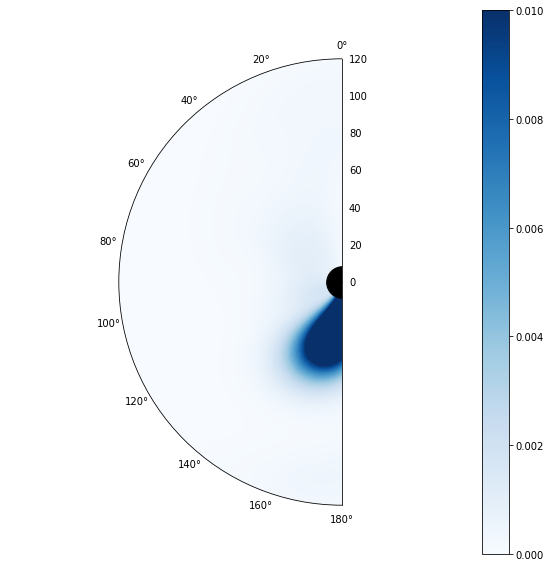

In [35]:
from scipy.stats import gaussian_kde

np.random.seed(0)
# get fake data for angles, measured in radians
angles = angle_df['angle_to_post_rad'].astype('float64')#
# and radii in [0, 1]
radii = angle_df['y_dist'].astype('float64')#

# Interpolation step:
N = 500 # number of points used to evaluate the interpolation
interp = gaussian_kde(np.vstack((angles, radii)))
# define ranges for interpolation
angles_ = np.linspace(0, np.pi, N)
radii_ = np.linspace(0, 120, N)

# to compute colors, first get the meshgrid of angles and radii with shape N x N x 2
mesh = np.stack(np.meshgrid(angles_, radii_), 0)
# compute N x N matrix of colors using `interp`

colors = interp(mesh.reshape(2, -1)).reshape(N, N)
h,x,y = np.histogram2d(angles,radii,density=True)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(projection='polar')

ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.grid(False)
ax1.set_theta_zero_location("N")

pc = ax1.pcolormesh(angles_, radii_, colors, cmap='Blues',vmin=0, vmax=0.01)
ax1.scatter(0, 0,s=1000, c='black', alpha=1)
fig.colorbar(pc, cmap='Blues')
plt.show()

### How do the similar neurons compare? 

To ensure that each neuron had a cleaned axon with at least 100 synapses we proofread and extended the nearest neurons, below we have provided the cleaned ids those neurons.

In [36]:
nonneurons = ['astrocyte','microglia','pericyte','oligo','OPC']

proofread_similar_neurons = [864691136924072932,864691136423829295,864691136380137941,864691135447698772,
864691135105346637,864691135518618250,864691136066776728,864691135293114294,864691135441778504,
864691135754961869,864691135408430793,864691135857355566,864691136135752843,864691135577985285,
864691135783548467,864691135940895398,864691135349629143,864691135615313099,864691135927639764,
864691136287658435,864691135640081723]

In [37]:
sample_root_id = 864691136423829295 #closest neuron in the perisomatic space

syn_out = get_syn_out_df(sample_root_id)
angle_df = get_angle_df(syn_out)

/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


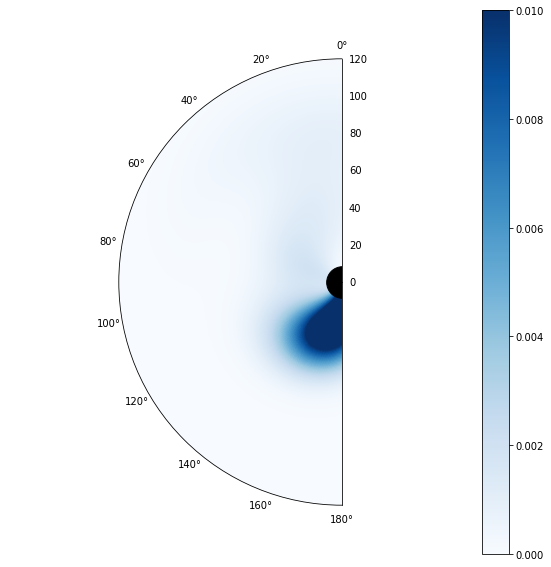

In [38]:
np.random.seed(0)
# get fake data for angles, measured in radians
angles = angle_df['angle_to_post_rad'].astype('float64')#
# and radii in [0, 1]
radii = angle_df['y_dist'].astype('float64')#

# Interpolation step:
N = 500 # number of points used to evaluate the interpolation
interp = gaussian_kde(np.vstack((angles, radii)))
# define ranges for interpolation
angles_ = np.linspace(0, np.pi, N)
radii_ = np.linspace(0, 120, N)

# to compute colors, first get the meshgrid of angles and radii with shape N x N x 2
mesh = np.stack(np.meshgrid(angles_, radii_), 0)
# compute N x N matrix of colors using `interp`

colors = interp(mesh.reshape(2, -1)).reshape(N, N)
h,x,y = np.histogram2d(angles,radii,density=True)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(projection='polar')

ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.grid(False)
ax1.set_theta_zero_location("N")

pc = ax1.pcolormesh(angles_, radii_, colors, cmap='Blues',vmin=0, vmax=0.01)
ax1.scatter(0, 0,s=1000, c='black', alpha=1)
fig.colorbar(pc, cmap='Blues')
plt.show()

Now let's look at them all, note that the first row in this histogram is our chandelier cell of interest.

In [39]:
#Calculating the angles for all the post synaptic targets for each neuron
#NOTE this takes about two minutes to run 
neighbor_df = pd.DataFrame()
for ix,root_id in enumerate(proofread_similar_neurons): #similar_neuron_nuc_ids

    syn_out = get_syn_out_df(root_id)
    angle_df = get_angle_df(syn_out)
    angle_df['order_ix'] = [ix]*angle_df.shape[0]
    angle_df = angle_df.query('target_ct not in @nonneurons')
    neighbor_df = pd.concat([neighbor_df, angle_df])

In [40]:
#Binning the data for an angular histogram
bins = [0, 20, 40, 60, 80, 100, 120, 140, 160,180]
labels = [20, 40, 60, 80, 100, 120, 140, 160,180]
neighbor_df['binned'] = pd.cut(neighbor_df['angle_to_post_deg'], bins, labels=labels)
#rand_df['binned'] = pd.cut(rand_df['angle_to_post_deg'], bins, labels=labels)

binned_df = neighbor_df.groupby(['pre_pt_root_id','binned']).size().unstack(fill_value=0)
binned_df = binned_df.div(binned_df.sum(axis=1), axis=0)
binned_df = binned_df.merge(neighbor_df[['pre_pt_root_id','order_ix']], how='left',
                           on='pre_pt_root_id')
binned_df = binned_df.sort_values('order_ix')
binned_df = binned_df.drop_duplicates()
binned_df = binned_df.reset_index()

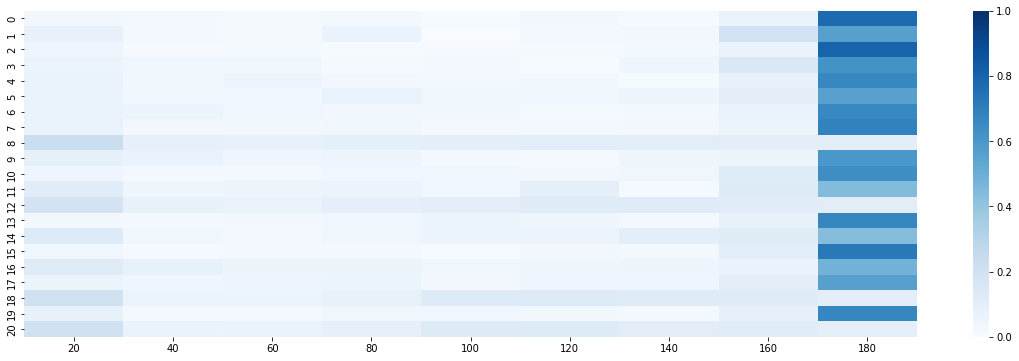

In [41]:
fig = plt.figure(figsize=(20,6))
sns.heatmap(binned_df[labels],cmap='Blues',vmin=0,vmax=1.0)
plt.show()

### How does this compare to a random sampling of inhibitory neurons? 

In [42]:
# To recreate the figures from the manuscript, the following random IDs were proofread with the same criteria as above
rand_ids = [864691135293116598,864691135911002793,864691135919637424,864691135387761025,
            864691135492620895,864691136228235089,864691135495538320,864691135940893606,
            864691136274097854,864691136391618431,864691136040542718,864691135940896678,
            864691136124889894,864691135489467194,864691135808625181,864691135919636912,
            864691135756014802,864691135447701332,864691134918590730,864691135874736782]

In [43]:
rand_df = pd.DataFrame()
for ix,root_id in enumerate(rand_ids):

    syn_out = get_syn_out_df(root_id)
    angle_df = get_angle_df(syn_out)
    angle_df['order_ix'] = [ix]*angle_df.shape[0]
    angle_df = angle_df.query('target_ct not in @nonneurons')
    rand_df = pd.concat([rand_df, angle_df])

In [44]:
rand_df['binned'] = pd.cut(rand_df['angle_to_post_deg'], bins, labels=labels)
rand_binned_df = rand_df.groupby(['pre_pt_root_id','binned']).size().unstack(fill_value=0)
rand_binned_df = rand_binned_df.div(rand_binned_df.sum(axis=1), axis=0)
rand_binned_df = rand_binned_df.merge(rand_df[['pre_pt_root_id','order_ix']], how='left',
                           on='pre_pt_root_id')
rand_binned_df = rand_binned_df.sort_values('order_ix')
rand_binned_df = rand_binned_df.drop_duplicates()
rand_binned_df = rand_binned_df.reset_index()

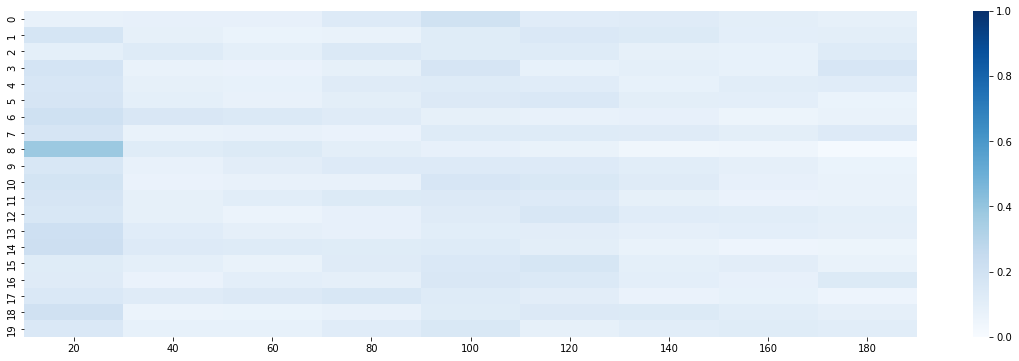

In [45]:
fig = plt.figure(figsize=(20,6))
sns.heatmap(rand_binned_df[labels],cmap='Blues',vmin=0,vmax=1.0)
plt.show()